Welcome to the W-analysis ROOTbook. Here we will show an example using a minimal amount of code for analysing a set of datasets holding simulated and measured data. The code is geared towards simplicity and the consequences of this approach will be pointed out where they apply and will be stated in comments in the code itself.

The analysis presented here is designed to select events containing a lepton-neutrino pair stemming from a single W boson. This is one of the more abundant processes found at the LHC.
In order to do this we are going to select events with one well identified charged lepton (more specifically a muon so there is less QCD background) and missing transverse momentum which indicates the presence of a neutrino. Furthermore we will deduct some information on the W boson from the measured quantities and use that for selection purposes by calculating the so-called transverse mass of the W boson.

To start we will introduce some utility function to make our live easier.

In [1]:
%%cpp -d
// Here, we define a function which takes a histogram and puts it in a map so that we can have
// container which links a certain string to a given histogram.
// This function is not entirely necessary but enables us to register a new histogram in
// one line.
TH1F* addHistogram(std::map<std::string, TH1F*>& histograms, TH1F* histogram){
    histograms[histogram->GetName()] = histogram;
    return histogram;
}

This function takes the url where the ROOT-file for a given dataset is stored, opens the file and extracts the 
relevant information for data analysis. The switch isMC is needed because measured data is treated slightly 
differently than simulated data. The parameter lumiWeight stores a factor which translates the number of events 
selected from the dataset to the number of events one would expect for the simulated process in a sample with
a certain luminosity.

In [2]:
%%cpp -d

// The result of this function is a map std::string -> histogram (TH1F*) which is used later for drawing the results
std::map<std::string, TH1F*> doAnalysis(std::string FileInputLocation, bool isMC, Double_t lumiWeight){
// Options
Float_t fraction = 0.1;  // This value can be adjusted so that one does not run over all the data, speeds things up

// Here we take the location of the data file and extract the TTree holding the information inside it    
TChain *InputSignal = new TChain("mini");
InputSignal->Add(FileInputLocation.c_str());
    
// These are the variables associated with the charged leptons in the tuple.
// It is usually not good to pair two instructions one one line but I felt that it illustrates the connection
// between the variables and how they are tied to the information in the TTree via the SetBranchAddress method more clearly
Int_t   lep_n;                    InputSignal->SetBranchAddress("lep_n",                 &lep_n);
Float_t lep_pt[5];                InputSignal->SetBranchAddress("lep_pt",                &lep_pt);
Float_t lep_eta[5];               InputSignal->SetBranchAddress("lep_eta",               &lep_eta);
Float_t lep_phi[5];               InputSignal->SetBranchAddress("lep_phi",               &lep_phi);
Float_t lep_E[5];                 InputSignal->SetBranchAddress("lep_E",                 &lep_E);
Int_t   lep_type[5];              InputSignal->SetBranchAddress("lep_type",              &lep_type);
Int_t   lep_flag[5];              InputSignal->SetBranchAddress("lep_flag",              &lep_flag);
Float_t lep_charge[5];            InputSignal->SetBranchAddress("lep_charge",            &lep_charge);
Float_t lep_etcone20[5];          InputSignal->SetBranchAddress("lep_etcone20",          &lep_etcone20);
Float_t lep_ptcone30[5];          InputSignal->SetBranchAddress("lep_ptcone30",          &lep_ptcone30);
Float_t lep_z0[5];                InputSignal->SetBranchAddress("lep_z0",                &lep_z0);
Float_t lep_d0[5];                InputSignal->SetBranchAddress("lep_trackd0pvunbiased", &lep_d0);

// These are the necessary variables associated with the missing transverse momentum which is our 
// best way of measuring the properties of particles that escaped detection (e.g. neutrinos)
Float_t met_et;                   InputSignal->SetBranchAddress("met_et",   &met_et);
Float_t met_phi;                  InputSignal->SetBranchAddress("met_phi",  &met_phi);

// The pile-up scale factor is needed to correct for different conditions during proton-proton collisions
// between the simulated and measured data.
Float_t ScaleFactor_PILEUP;

// The mcWeight is a number used in simulations
Float_t mcWeight;

// as said, some variables are stored differently in measured and simulated data.
// In measured data both mcWeight and scaleFactor_PILEUP are set to zero, so we have to set them to 1 manually
if (isMC){
  InputSignal->SetBranchAddress("mcWeight",   &mcWeight);
  InputSignal->SetBranchAddress("scaleFactor_PILEUP",   &ScaleFactor_PILEUP);
}
else{
    mcWeight = 1.0;
    ScaleFactor_PILEUP = 1.0;   
}
        
// Here we start declaring some histograms and put them into the map of histograms which is the output of this function
std::map<std::string, TH1F*> histograms;
// please refer to the documentation of TH1F to find out about creation of these objects (google TH1F)
TH1F* hist_lep_pt  = addHistogram(histograms, new TH1F("h_lep_pt","Transverse Momentum Lepton;Lepton pt [GeV]"  ,20,0,200));
TH1F* hist_lep_eta = addHistogram(histograms, new TH1F("h_lep_eta","Pseudo Rapidity Lepton;Lepton #eta",25,-2.5,2.5));
TH1F* hist_etmiss  = addHistogram(histograms, new TH1F("h_etmiss","Missing Transverse Momentum;MET [GeV]"  ,20,0,200));
TH1F* hist_wtmass  = addHistogram(histograms, new TH1F("h_wtmass","W Boson Transverse Mass;WTMass [GeV]"  ,30,40,160));


// This concludes our setup phase. Now we can start looping over the events in the samples.
Int_t nEvents = Int_t(InputSignal->GetEntries()*fraction);
std::cout << " Number of entries  " << nEvents << endl;

Int_t PassedEvents = 0;
for (int i = 0; i < nEvents ;++i) {
  // read in the information for the event at hand
  InputSignal->GetEntry(i);
    
  // First thing is to check that we only have one good lepton (as required)
  Int_t nGoodLeptons = 0;
  Int_t gLI = 0;
  // We check each lepton whether it satisfies certain criteria
  for (int j = 0; j < lep_n; ++j){
    if (lep_type[j] != 13) continue;                   // This ensures that the lepton is a muon (13) (electron is 11)
    if (bool(lep_flag[j] & 512) == false) continue;    // This ensures that the lepton is well measured (a bit cryptic...)
    if (lep_pt[j] < 25000) continue;                   // The lepton has to have a transverse momentum > 25 GeV
    if (lep_eta[j] > 2.5)  continue;                   // The lepton has to lie within the range were tracking is available
    if (lep_etcone20[j]/lep_pt[j] > 0.1) continue;     // the lepton should be well isolated
    if (lep_ptcone30[j]/lep_pt[j] > 0.1) continue;
    nGoodLeptons++;
    gLI = j;
  }
    
  // more or less than one good lepton would indicate other processes, so these are vetoed
  if (nGoodLeptons != 1) continue;
    
  // Next we want to know whether the transverse mass of the W candidate defined by the charged lepton and the missing
  // transverse momentum is ok. For this we have to calculate the transverse mass first
  TLorentzVector Lepton = TLorentzVector();
  TLorentzVector MET    = TLorentzVector();
    
  // The factors 0.001 are used to convert the pt-information stored in MeV to GeV which is easier to use
  Lepton.SetPtEtaPhiE(lep_pt[gLI]*0.001, lep_eta[gLI], lep_phi[gLI], lep_E[gLI]*0.001);
  MET.SetPtEtaPhiE(met_et*0.001, 0, met_phi, met_et*0.001);
    
  Float_t TransMass = TMath::Sqrt(2*Lepton.Pt()*MET.Pt()*(1-TMath::Cos(Lepton.DeltaPhi(MET))));        
    
  // Now, we check the requirements for the selection one by one
  if (TransMass < 30 ) continue;
  if (MET.Pt()  < 30 ) continue;
    
  // If everything is ok, we can fill the histograms
  PassedEvents++;
  hist_lep_pt->Fill(Lepton.Pt(), mcWeight*lumiWeight*ScaleFactor_PILEUP);
  hist_lep_eta->Fill(Lepton.Eta(), mcWeight*lumiWeight*ScaleFactor_PILEUP);
  hist_etmiss->Fill(MET.Pt(), mcWeight*lumiWeight*ScaleFactor_PILEUP);
  hist_wtmass->Fill(TransMass, mcWeight*lumiWeight*ScaleFactor_PILEUP);
}

std::cout << " Passed Events: " << PassedEvents << std::endl;

return histograms;
}

The function we just wrote encapsulates the whole analysis logic. Adding or removing samples from our selection is now 
very easy as can be seen in the next cell. There we will analyse a string of samples of simulated events and register 
the obtained histograms in a map. If we want to add a new sample we can do so in one line.

In [3]:
// This is just here to get rid of some warnings
TH1::AddDirectory(kFALSE);

std::map<std::string, std::map<std::string,TH1F*>> processHistogramsMap;
processHistogramsMap["WMunuWithB"]       = doAnalysis("http://atlas-opendata.web.cern.ch/atlas-opendata/release/samples/MC/mc_167743.WmunuWithB.root", true, 0.289);
processHistogramsMap["WmunuJetsBVeto"]   = doAnalysis("http://atlas-opendata.web.cern.ch/atlas-opendata/release/samples/MC/mc_167744.WmunuJetsBVeto.root", true, 0.328);
processHistogramsMap["WmunuNoJetsBVeto"] = doAnalysis("http://atlas-opendata.web.cern.ch/atlas-opendata/release/samples/MC/mc_167745.WmunuNoJetsBVeto.root", true, 1.0417);
processHistogramsMap["Zmumu"]            = doAnalysis("http://atlas-opendata.web.cern.ch/atlas-opendata/release/samples/MC/mc_147771.Zmumu.root", true, 0.0000000441759);

auto dataHists = doAnalysis("http://atlas-opendata.web.cern.ch/atlas-opendata/release/samples/Data/DataMuons.root", false, 1.0);

 Number of entries  75000
 Passed Events: 51101
 Number of entries  250000
 Passed Events: 160909
 Number of entries  750000
 Passed Events: 524825
 Number of entries  750000
 Passed Events: 141950
 Number of entries  702808
 Passed Events: 362428


The following function is used to make a unified depiction of the simulated data in the form of a stack of contributions. Right now we have a map of processes and their histograms looking like this:
Process1 -> histogram_name1 -> histogram11
         -> histogram_name2 -> histogram12
Process2 -> histogram_name1 -> histogram21
         -> histogram_name2 -> histogram22

Now we are going to make stacks for each histogram (e.g. lep_pt) showing the individual contributions by the processes.

In [4]:
%%cpp -d
std::map<std::string, THStack*> makeStacks(std::map<std::string, std::map<std::string, TH1F*>> processHistograms, std::map<std::string, Int_t> colours){
  // first we make a map of the histogram name linking to the final stack we want to have
  std::map<std::string, THStack*> stacks;

  // now, we loop over all processes and combine the information for the different histograms into stacks
  for(auto &process : processHistograms) {
     for (auto &histogram : process.second) {
       // We create the stack if it is not available yet
       if (stacks.find(histogram.first) == stacks.end()){
          auto stack = new THStack();
          stacks[histogram.first] = stack;

       }
       // we adjust the colouring for each process and add it to the stack
       histogram.second->SetFillColor(colours[process.first]);
       stacks[histogram.first]->Add(histogram.second);
     }
  }
    
  return stacks;
}

We just saw that we want to have certain colours for our processses. These are defined in the next cell.

In [5]:
std::map< std::string, Int_t> colours;
colours["WMunuWithB"]       = kBlue;
colours["WmunuJetsBVeto"]   = kBlue;
colours["WmunuNoJetsBVeto"] = kBlue;
colours["Zmumu"] = kGreen;

Now we have the individual stacks. We want to compare this to the measured data. To make things easier in the long run 
we decide to write another function which details how the individual depcitions should be drawn.

In [6]:
%%cpp -d
TCanvas* paintCanvas(TCanvas* canvas, Int_t index, std::string key, std::map<std::string, THStack*>& stacksMap, std::map<std::string, TH1F*> dataHists){
  // we go to the given index in the canvas
  canvas->cd(index);

  // we get the histogram for the measured data according to the provided key and style it a bit
  auto dataHist = dataHists[key];
  dataHist->SetLineColor(kBlack);
  dataHist->SetMarkerColor(kBlack);
  dataHist->SetLineWidth(1);

  // we get the stack for the given key and draw everything
  auto stack = stacksMap[key];
  dataHist->Draw("E");
  stack->Draw("HISTsame");
  dataHist->Draw("Esame");
  return canvas;
}

Using these functions we can now draw everything in a compact way:

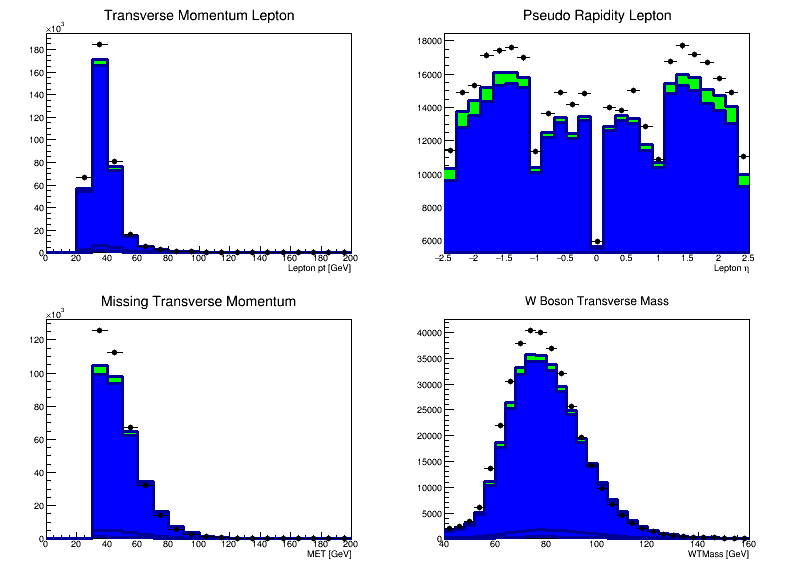

In [7]:
// We set up the canvas which holds the individual depictions
TCanvas *c1a = new TCanvas("canvas1","canvas1",50,50,800,600);
c1a->SetFillColor(0);
gStyle->SetOptStat(0);
c1a->Divide(2,2);

// We build the individual stacks
stacksMap = makeStacks(processHistogramsMap, colours); 

// and paint everything
c1a = paintCanvas(c1a, 1, "h_lep_pt", stacksMap, dataHists);
c1a = paintCanvas(c1a, 2, "h_lep_eta", stacksMap, dataHists);
c1a = paintCanvas(c1a, 3, "h_etmiss", stacksMap, dataHists);
c1a = paintCanvas(c1a, 4, "h_wtmass", stacksMap, dataHists);
c1a->Draw();

And now we are done!